# Exercise 4: Image Classification


Given an input RGB image, you should train a neural network which outputs the class label the image belongs to.
There are six class labels in our dataset: "buildings", "forests", "mountains", "glacier", "sea", and "street".
In order to design and train your network, we provide a training set and validation set along with class labels for every image.
As you are already familiar, we separate the dataset into three splits: training, validation, and testing.
The train set has 6K images (1K per class), and the val and test sets each have 1.2K images (200 per class).

An overview of the desired pipeline is shown in Figure.


![](https://docs.google.com/drawings/d/e/2PACX-1vRynZcZ1jfCu1GAsY9Hww68kr3iGaHj5XKeQptkF9lRysFpMtbbs4TZZaklAemoZJbMR-LUQnVkkI0b/pub?w=680&h=483 "Title")


This exercise acts as a gentle introduction to [PyTorch](https://pytorch.org/), one of the most popular deep learning frameworks.
We provide a majority of the code to get you started and familiarized with the framework.
Running through all the cells will give you a simple network that should serve you as a good starting point for improvement.
To pass, you will need to modify the given implementation and train a network that can achieve better performance.

**Evaluation Criteria**

Your algorithm will be evaluated using classification accuracy, which is the proportion of images with the correct predicted label.
The final EvaluationScore is obtained as the classification accuracy over all test samples.

**Passing requirement**

Your algorithm will be evaluated on a test set. In order to pass the exercise, you need to obtain an EvaluationScore beating **iacvbaseline**.

## Initialize the environment and load data
Import the necessary libraries. Note that you are **NOT** allowed to use any additional libraries

In [14]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt

import sys
import shutil
from pathlib import Path
import numpy as np

def is_colab():
    return 'google.colab' in sys.modules

import torch
from torch.utils.data import DataLoader
if is_colab():
    from google.colab import drive
    
    drive_path = Path('/content/drive')
    drive.mount(str(drive_path), force_remount=True)

    ex_path = 'MyDrive/ex4_dl_classification'
    ex_path = drive_path / ex_path


else:
    ex_path = Path(r"C:/Users/tovon/projects_programming/IACV/ex4_dl_classification")
    data_path = ex_path / Path('data')

# Possibly append to PATH
if ex_path not in sys.path:
    sys.path.append(str(ex_path))

print(f"ex_path: {ex_path}")


from utils import show_images


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ex_path: C:\Users\tovon\projects_programming\IACV\ex4_dl_classification


## Overview

In general, training any deep learning models consists of the following components


*   **Dataset:** The data on which the model is trained. This could be e.g. large number of images, videos, text documents etc.
*   **Model:** The network architecture we want to train. A significant part of developing deep learning solutions involves designing right architecture for a given problem.
*   **Cost Function:** The criteria which is minimized over our dataset to train the network, e.g. Cross-entropy loss, Mean-squared error.  
*   **Optimizer:** The optimizer updates the model parameters to minimize the cost function. The most common example is Stochastic Gradient Descent. One also has to determine hyperparameters such as the learning rate, number of optimization iterations etc.

As discussed in the lectures, the deep networks are trained using *mini-batches*, which are a set of training images (commonly between 8-128). Furthermore, data augmentation strategies (e.g. rotating an image) are commonly used to 'transform' the training images first, before passing it to a network. Thus, the data loading step itself can be broken down into following sub-steps,
1.   Load an image from the dataset. The images are randomly loaded from the dataset during training to avoid any bias.
2.   Apply necessary pre-processing to the image, e.g. remove mean, convert datatype to `float` etc.
3.   Apply desired data augmentations to the image, e.g. rotate an image, extract a random crop from the image.
4. Group a number of processed images to form a 'training batch'. This batch is then passed through the network to obtain predictions and compute loss.




We will use the [PyTorch](https://pytorch.org/) deep learning framework to implement each of these components. Follow through the next cells to check the implementation.


## Step 1: Data Loading

We first take a look at how to define the datasets and data loading procedures in PyTorch.

To do so, we need to create a PyTorch Dataset and DataLoader.
The PyTorch Dataset handles loading the actual images and labels from file as well as applying any transformations on the loaded image. To define your own Dataset, you need to subclass the `torch.utils.data.Dataset` class and implement three functions:

1. `__init__`: Initialize the dataset.
2. `__len__`: Returns the number of samples in the dataset.
3. `__getitem__`: Given a specific index, load the corresponding images and labels and return them. Necessary transformations are commonly applied here, too.

We have implemented a dataset class for our task.
We have also implemented some basic transformations - you might want to add more augmentation strategies later.
Please take a close look at the file `dataset.py` to see how it's done.

In [15]:
from dataset import ImageDataset
from transforms import get_transforms_train, get_transforms_val

# DataLoader for training data (Transforms include preprocessing + augmentation)
dataset_train = ImageDataset(data_path/'train.csv', data_path/'train.hdf5', get_transforms_train())

# DataLoader for validation data (Transforms include only preprocessing)
dataset_valid = ImageDataset(data_path/'val.csv', data_path/'val.hdf5', get_transforms_val())

Note that the PyTorch Dataset only deals with loading a single image at a time.
The data sampling logic for loading multiple images is handled by the PyTorch DataLoader, which takes the Dataset as input and defines the logic for how to iterate over the entire dataset. To create the DataLoader, you need to use `torch.utils.data.DataLoader`, which has the following arguments:

- `dataset`: A PyTorch Dataset.
- `batch_size`: Number of images to load at a time.
- `shuffle`: Whether to shuffle the dataset before loading the images. Usually, you will use shuffling during training and not during testing.
- `num_workers`: Number of subprocesses to use for data loading.
- ... and many more. You can find the full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).


We now create DataLoaders for our training and validation datasets.

In [25]:
batch_size = 8
num_workers = 3

# Generate our data loaders
train_loader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(dataset_valid, batch_size, shuffle=True, num_workers=num_workers)

Visualize a few training samples along with the ground truth labels to get an idea of how the images look. You can run this multiple times to check different images

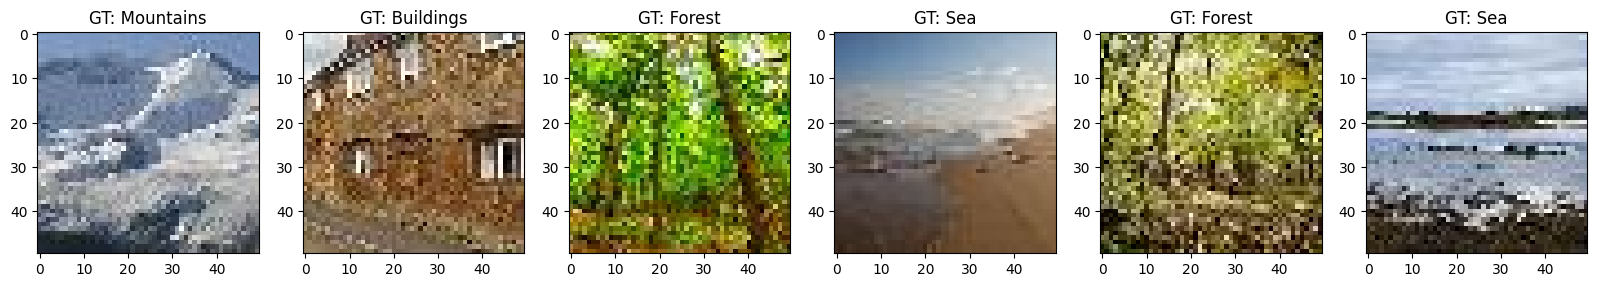

In [21]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images(images[:6], labels[:6])

## Step 2: Define the Network

After we've set up the data, we now need to define the network we will use to perform image classification.

To do so, we need to create a PyTorch network.
To define your own PyTorch network, you need to subclass the `torch.nn.Module` class and implement two functions:

1. `__init__`: Initialize the network, defining all the layers in the network to use.
2. `forward`: Defines the forward pass of the network, which takes an image as input and outputs classification scores for each class.

As you will notice, we only have to define the forward pass of the network but not the backward pass (backpropagation). This is because PyTorch handles computing gradients for each operation for you ([autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)), so you don't have to worry about it at all!

We've implemented a very simple CNN for you already in `cnn_network.py` with a single convolutional layer, pooling layer, and fully-connected layer. You can run this cell to see the network architecture as well as test the forward pass of the network.

**Important:** Don't forget to import the `cnn_network.py` file every time you modify it, otherwise your latest changes won't be loaded.

In [22]:
from cnn_network import CNN

cnn_network = CNN()  # create CNN model

print("CNN Architecture:")
print(cnn_network)

print("")
print("Testing network input / output.")
test_input = torch.zeros(1, 3, 50, 50)  # batch size X 3 (RGB) X width X height
print(f"Input shape: {test_input.shape}")
test_output = cnn_network(test_input)  # batch size X # classes
print(f"Output shape: {test_output.shape}")

assert tuple(test_output.shape) == (1, 6), "Output shape should be [1, 6]"

CNN Architecture:
CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=150, out_features=6, bias=True)
)

Testing network input / output.
Input shape: torch.Size([1, 3, 50, 50])
Output shape: torch.Size([1, 6])


## Step 3: Define the cost function and the optimizer

Next we define the cost function and the optimizer to be used for training.

For the image classification task, the most commonly used loss function is the Cross-Entropy loss, which we will use here. However, feel free to play around with other losses you can think of.

We will use the Stochastic-Gradient descent optimizer. The optimizer contains two hyperparameters, namely the learning rate and the momentum. You are free to test other optimizers. Note that PyTorch gives implementations of commonly used optimizers such as SGD, Adam, etc.

Please check the `cnn_network.py` file to see how these components are defined.

In [23]:
from cnn_network import get_loss_function, get_optimizer

criterion = get_loss_function()  # get loss function
optimizer = get_optimizer(cnn_network, lr=0.001, momentum=0.9)  # get optimizer

## Step 4: Train the Network

Now that we've defined both the data and the network, it's time to train our network on the data.

To do so, we simply just iterate over each batch of data, compute the network loss, then optimize the network parameters with backpropagation. See the code below for details on the right way to do this in PyTorch.

Run this cell to train the network.
This may take some time.
You should see the training loss go down in the initial iterations then plateau.

**Note:** We reinitialize the network, and load dataset, optimizer, loss function etc again here so that it is convenient to modify them in a single place.

In [24]:
from dataset import ImageDataset
from transforms import get_transforms_val, get_transforms_train
from cnn_network import CNN, get_loss_function, get_optimizer

# *********************************************************** #
# set all training parameters. You can play around with these
# *********************************************************** #

batch_size = 8           # Number of images in each batch
learning_rate = 0.001    # Learning rate in the optimizer
momentum = 0.9           # Momentum in SGD
num_epochs = 2           # Number of passes over the entire dataset
print_every_iters = 100  # Print training loss every X mini-batches


# *********************************************************** #
# Initialize all the training components, e.g. model, cost function
# *********************************************************** #

# Get transforms
transform_train = get_transforms_train()
transform_val = get_transforms_val()

# Generate our data loaders
dataset_train = ImageDataset(data_path/'train.csv', data_path/'train.hdf5', get_transforms_train())
dataset_valid = ImageDataset(data_path/'val.csv', data_path/'val.hdf5', get_transforms_val())

train_loader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset_valid, batch_size, shuffle=True, num_workers=2)

# create CNN model
cnn_network = CNN()

# Get optimizer and loss functions
criterion = get_loss_function()
optimizer = get_optimizer(cnn_network, lr=learning_rate, momentum=momentum)



# *********************************************************** #
# The main training loop. You dont need to change this
# *********************************************************** #
training_loss_per_epoch = []
val_loss_per_epoch = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # Put the model in training mode
    cnn_network.train()

    # First we loop over training dataset
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()  # zero the gradients from previous iteration

        # forward + backward + optimize
        outputs = cnn_network(inputs)  # forward pass to obtain network outputs
        loss = criterion(outputs, labels)  # compute loss with respect to labels
        loss.backward()  # compute gradients with backpropagation (autograd)
        optimizer.step()  # optimize network parameters

        # print statistics
        running_loss += loss.item()
        if (i + 1) % print_every_iters == 0:
            print(
                f'[Epoch: {epoch + 1} / {num_epochs},'
                f' Iter: {i + 1:5d} / {len(train_loader)}]'
                f' Training loss: {running_loss / (i + 1):.3f}'
            )

    mean_loss = running_loss / len(train_loader)
    training_loss_per_epoch.append(mean_loss)

    # Put model in evaluation mode for validation
    # This is important for some methods, eg. dropout
    cnn_network.eval()

    # Loop over validation dataset
    running_loss = 0.0
    for i, data in enumerate(valid_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # on validation dataset, we only do forward, without computing gradients
        with torch.no_grad():
            outputs = cnn_network(inputs)  # forward pass to obtain network outputs
            loss = criterion(outputs, labels)  # compute loss with respect to labels

        # print statistics
        running_loss += loss.item()

    mean_loss = running_loss / len(valid_loader)
    val_loss_per_epoch.append(mean_loss)

    print(
        f'[Epoch: {epoch + 1} / {num_epochs}]'
        f' Validation loss: {mean_loss:.3f}'
    )

print('Finished Training')

# Plot the training curves
plt.figure()
plt.plot(np.array(training_loss_per_epoch))
plt.plot(np.array(val_loss_per_epoch))
plt.legend(['Training loss', 'Val loss'])
plt.xlabel('Epoch')
plt.show()
plt.close()

TypeError: h5py objects cannot be pickled

## Step 5: Test the Network

After training the network, it is time to test our network on the validation set, which includes images not seen during training. This will tell us how well the network can perform on new data.

We first visualize several network predictions on validation samples along with the ground truth labels.
You can run this cell multiple times to visualize different images.

In [ ]:
# get a few validation samples
images, labels = next(iter(valid_loader))

# get network output
outputs = cnn_network(images)  # classification scores
_, predicted = torch.max(outputs, 1)  # use maximum as prediction label

# visualize ground truth and predictions
show_images(images[:4], labels[:4], predicted[:4])

To get the full picture of the network performance, we need to evaluate on the full validation set.
This cell will iterate over every validation image, obtain the network prediction, and compare with the corresponding ground truth.
The evaluation score is the percentage of labels predicted correctly.
This may take some time.
You should see an accuracy of around 63%.

In [ ]:
from utils import compute_accuracy

acc = compute_accuracy(cnn_network, valid_loader)
print(f'Accuracy of the network on the 1500 validation images: {acc:.2f} %')

## Your Turn

**TODO:** We provided a simple CNN and boilerplate training code to introduce PyTorch to you.
These are written in their simplest form to leave ample room for extension.
Your task is to improve the network's performance on the test set.

**Note:** You are not allowed to use any external packages except the ones already imported in `cnn_network.py`. Otherwise your submission will crash on the Evaluation server.


**Hints:** Things that can potentially improve test accuracy:
- Deeper architecture: Adding more layers can lead to better performance, but be careful of overfitting to the training set!
- Activation functions: Introducing activation functions can increase the capacity of the network.
- Training parameters: Modifying the length of training, learning rate, optimizer, loss function, etc. can all improve network performance, but again be careful of overfitting!
- Transforms: Adding data transforms essentially generates more data for training, which helps alleviate overfitting. See full list of available transforms [here](https://pytorch.org/vision/stable/transforms.html).

## Generate the final submission on the test set

When you are happy with your network, you can run the next cell to generate your submission.
We will copy the relevant files, as well as save the learned model parameters to the submission folder.
As usual, download the submission folder as a zip, and upload it to the evaluation server. There your code will run to predict the test image labels.

In [ ]:
out_dir = env_path / 'submission'
out_dir.mkdir(exist_ok=True)

cnn_network.write_weights(out_dir / 'checkpoint.pt')
shutil.copyfile(env_path / 'cnn_network.py', out_dir / 'cnn_network.py')
shutil.copyfile(env_path / 'transforms.py', out_dir / 'transforms.py')

print("Done. You can submit now.")